<a href="https://colab.research.google.com/github/naomifridman/Introduction_to_deep_learning/blob/master/Deep_Learning_keras_boston_regression_and_training_tools.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Introduction to Deep Learning 
# Training DNN with Keras
### boston house price regression example
* https://www.kaggle.com/c/house-prices-advanced-regression-techniques/data
* https://towardsdatascience.com/deep-neural-networks-for-regression-problems-81321897ca33

In [0]:
import matplotlib.pyplot as plt
import pandas as pd

import numpy as np
import matplotlib.gridspec as gridspec
from sklearn.metrics import accuracy_score, log_loss

%matplotlib inline  

## Utilities

In [0]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import cohen_kappa_score

def print_stats(ytest, ypred):
    
    print("Accuracy: {:.5f}, Cohen's Kappa Score: {:.5f}".format(
        accuracy_score(ytest, ypred), 
        cohen_kappa_score(ytest, ypred, weights="quadratic")))
    print("Confusion Matrix:")
    print(confusion_matrix(ytest, ypred))
    print("Classification Report:")
    print(classification_report(ytest, ypred))

In [0]:
def drow_history_list(history_list, history_names=None,  metric=None):
    
    if metric is None:
        metric = 'loss'
        
    leg = []
    if history_names is not None:
        for n in history_names:
            leg.append('train ' + n)
            leg.append('test ' + n)
    else:
        for n in range(len(history_list)):
            leg.append('train ' + str(n))
            leg.append('test ' + str(n))
            
    for hist in history_list:
        
        plt.plot(hist.history[metric])
        plt.plot(hist.history['val_'+ metric], '--', linewidth=2)
        
        
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(leg, loc='best')
    plt.show()  

In [0]:
def drow_history(history, metric, i_start=0):
    if metric is None:
        metric = 'loss'
    plt.plot(history.history[metric][i_start:])
    plt.plot(history.history['val_'+ metric][i_start:])
    plt.title('model '+metric)
    plt.ylabel(metric)
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()    

In [6]:
import keras
# Keras has many build in data sets
from keras.datasets import mnist
# Sequential is the basic feed forward neural network (FFN)
from keras.models import Sequential
# Dense is fully connected layer
# Dropout is a "noising" layer, to prevent over feet.
from keras.layers import Dense, Dropout
# Read about optimizers in keras documentation
from keras.optimizers import RMSprop
from keras import optimizers

Using TensorFlow backend.


## Read data and Pre-process

In [0]:
from sklearn.datasets import make_moons, make_circles, make_classification
from sklearn.preprocessing import StandardScaler, MaxAbsScaler
from sklearn.model_selection import train_test_split
from matplotlib.colors import ListedColormap
from sklearn.metrics import accuracy_score

Data fields
* Here's a brief version of what you'll find in the data description file.

* SalePrice - the property's sale price in dollars. This is the target variable that you're trying to predict.
* MSSubClass: The building class
* MSZoning: The general zoning classification
* LotFrontage: Linear feet of street connected to property
* LotArea: Lot size in square feet
* Street: Type of road access
* Alley: Type of alley access
* LotShape: General shape of property
* LandContour: Flatness of the property
* Utilities: Type of utilities available
* LotConfig: Lot configuration
* LandSlope: Slope of property
* Neighborhood: Physical locations within Ames city limits
* Condition1: Proximity to main road or railroad
* Condition2: Proximity to main road or railroad (if a second is present)
* BldgType: Type of dwelling
* HouseStyle: Style of dwelling
* OverallQual: Overall material and finish quality
* OverallCond: Overall condition rating
* YearBuilt: Original construction date
* YearRemodAdd: Remodel date
* RoofStyle: Type of roof
* RoofMatl: Roof material
* Exterior1st: Exterior covering on house
* Exterior2nd: Exterior covering on house (if more than one material)
* MasVnrType: Masonry veneer type
* MasVnrArea: Masonry veneer area in square feet
* ExterQual: Exterior material quality
* ExterCond: Present condition of the material on the exterior
* Foundation: Type of foundation
* BsmtQual: Height of the basement
* BsmtCond: General condition of the basement
* BsmtExposure: Walkout or garden level basement walls
* BsmtFinType1: Quality of basement finished area
* BsmtFinSF1: Type 1 finished square feet
* BsmtFinType2: Quality of second finished area (if present)
* BsmtFinSF2: Type 2 finished square feet
* BsmtUnfSF: Unfinished square feet of basement area
* TotalBsmtSF: Total square feet of basement area
* Heating: Type of heating
* HeatingQC: Heating quality and condition
* CentralAir: Central air conditioning
* Electrical: Electrical system
* 1stFlrSF: First Floor square feet
* 2ndFlrSF: Second floor square feet
* LowQualFinSF: Low quality finished square feet (all floors)
* GrLivArea: Above grade (ground) living area square feet
* BsmtFullBath: Basement full bathrooms
* BsmtHalfBath: Basement half bathrooms
* FullBath: Full bathrooms above grade
* HalfBath: Half baths above grade
* Bedroom: Number of bedrooms above basement level
* Kitchen: Number of kitchens
* KitchenQual: Kitchen quality
* TotRmsAbvGrd: Total rooms above grade (does not include bathrooms)
* Functional: Home functionality rating
* Fireplaces: Number of fireplaces
* FireplaceQu: Fireplace quality
* GarageType: Garage location
* GarageYrBlt: Year garage was built
* GarageFinish: Interior finish of the garage
* GarageCars: Size of garage in car capacity
* GarageArea: Size of garage in square feet
* GarageQual: Garage quality
* GarageCond: Garage condition
* PavedDrive: Paved driveway
* WoodDeckSF: Wood deck area in square feet
* OpenPorchSF: Open porch area in square feet
* EnclosedPorch: Enclosed porch area in square feet
* 3SsnPorch: Three season porch area in square feet
* ScreenPorch: Screen porch area in square feet
* PoolArea: Pool area in square feet
* PoolQC: Pool quality
* Fence: Fence quality
* MiscFeature: Miscellaneous feature not covered in other categories
* MiscVal: $Value of miscellaneous feature
* MoSold: Month Sold
* YrSold: Year Sold
* SaleType: Type of sale
* SaleCondition: Condition of sale

In [10]:
import os
# DATA_IN_KAGGLE:
os.environ['KAGGLE_USERNAME']='ripcurl' #xxxxxx
os.environ['KAGGLE_KEY']='f18cea91f5001432043566dbd5a174c7' #xxxxxx

!kaggle competitions download -c house-prices-advanced-regression-techniques # api copied from kaggle

  0% 0.00/31.2k [00:00<?, ?B/s]
100% 31.2k/31.2k [00:00<00:00, 12.3MB/s]
  0% 0.00/441k [00:00<?, ?B/s]
100% 441k/441k [00:00<00:00, 62.7MB/s]
  0% 0.00/450k [00:00<?, ?B/s]
100% 450k/450k [00:00<00:00, 62.4MB/s]
  0% 0.00/13.1k [00:00<?, ?B/s]
100% 13.1k/13.1k [00:00<00:00, 13.2MB/s]


In [12]:
!ls

data_description.txt  sample_data  sample_submission.csv  test.csv  train.csv


In [13]:
train = pd.read_csv('train.csv')
train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,...,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,...,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,...,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,...,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,...,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,...,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [14]:
test = pd.read_csv('test.csv')
test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,NAmes,Feedr,Norm,1Fam,1Story,5,6,1961,1961,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,CBlock,TA,TA,No,Rec,468.0,LwQ,144.0,270.0,882.0,GasA,TA,Y,SBrkr,896,0,0,896,0.0,0.0,1,0,2,1,TA,5,Typ,0,NaN,Attchd,1961.0,Unf,1.0,730.0,TA,TA,Y,140,0,0,0,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,NAmes,Norm,Norm,1Fam,1Story,6,6,1958,1958,Hip,CompShg,Wd Sdng,Wd Sdng,BrkFace,108.0,TA,TA,CBlock,TA,TA,No,ALQ,923.0,Unf,0.0,406.0,1329.0,GasA,TA,Y,SBrkr,1329,0,0,1329,0.0,0.0,1,1,3,1,Gd,6,Typ,0,NaN,Attchd,1958.0,Unf,1.0,312.0,TA,TA,Y,393,36,0,0,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,5,5,1997,1998,Gable,CompShg,VinylSd,VinylSd,None,0.0,TA,TA,PConc,Gd,TA,No,GLQ,791.0,Unf,0.0,137.0,928.0,GasA,Gd,Y,SBrkr,928,701,0,1629,0.0,0.0,2,1,3,1,TA,6,Typ,1,TA,Attchd,1997.0,Fin,2.0,482.0,TA,TA,Y,212,34,0,0,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,Gilbert,Norm,Norm,1Fam,2Story,6,6,1998,1998,Gable,CompShg,VinylSd,VinylSd,BrkFace,20.0,TA,TA,PConc,TA,TA,No,GLQ,602.0,Unf,0.0,324.0,926.0,GasA,Ex,Y,SBrkr,926,678,0,1604,0.0,0.0,2,1,3,1,Gd,7,Typ,1,Gd,Attchd,1998.0,Fin,2.0,470.0,TA,TA,Y,360,36,0,0,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,Inside,Gtl,StoneBr,Norm,Norm,TwnhsE,1Story,8,5,1992,1992,Gable,CompShg,HdBoard,HdBoard,None,0.0,Gd,TA,PConc,Gd,TA,No,ALQ,263.0,Unf,0.0,1017.0,1280.0,GasA,Ex,Y,SBrkr,1280,0,0,1280,0.0,0.0,2,0,2,1,Gd,5,Typ,0,NaN,Attchd,1992.0,RFn,2.0,506.0,TA,TA,Y,0,82,0,0,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


### Combine train and test data to process them together

In [0]:
target = train.SalePrice
train.drop(['SalePrice'],axis = 1 , inplace = True)

combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop(['index', 'Id'], inplace=True, axis=1)

In [17]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 80 columns):
Id               1459 non-null int64
MSSubClass       1459 non-null int64
MSZoning         1455 non-null object
LotFrontage      1232 non-null float64
LotArea          1459 non-null int64
Street           1459 non-null object
Alley            107 non-null object
LotShape         1459 non-null object
LandContour      1459 non-null object
Utilities        1457 non-null object
LotConfig        1459 non-null object
LandSlope        1459 non-null object
Neighborhood     1459 non-null object
Condition1       1459 non-null object
Condition2       1459 non-null object
BldgType         1459 non-null object
HouseStyle       1459 non-null object
OverallQual      1459 non-null int64
OverallCond      1459 non-null int64
YearBuilt        1459 non-null int64
YearRemodAdd     1459 non-null int64
RoofStyle        1459 non-null object
RoofMatl         1459 non-null object
Exterior1st      1458 non-

In [0]:
def get_cols_with_no_nans(df,col_type):
    '''
    Arguments :
    df : The dataframe to process
    col_type : 
          num : to only get numerical columns with no nans
          no_num : to only get nun-numerical columns with no nans
          all : to get any columns with no nans    
    '''
    if (col_type == 'num'):
        predictors = df.select_dtypes(exclude=['object'])
    elif (col_type == 'no_num'):
        predictors = df.select_dtypes(include=['object'])
    elif (col_type == 'all'):
        predictors = df
    else :
        print('Error : choose a type (num, no_num, all)')
        return 0
    cols_with_no_nans = []
    for col in predictors.columns:
        if not df[col].isnull().any():
            cols_with_no_nans.append(col)
    return cols_with_no_nans

In [19]:
num_cols_train = get_cols_with_no_nans(train , 'num')
cat_cols_train = get_cols_with_no_nans(train , 'no_num')
print ('Number of numerical columns with no nan values :',len(num_cols_train))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols_train))

Number of numerical columns with no nan values : 34
Number of nun-numerical columns with no nan values : 27


In [20]:
num_cols_combined = get_cols_with_no_nans(combined , 'num')
cat_cols_combined = get_cols_with_no_nans(combined , 'no_num')
print ('Number of numerical columns with no nan values :',len(num_cols_combined))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols_combined))

Number of numerical columns with no nan values : 25
Number of nun-numerical columns with no nan values : 20


In [21]:
num_cols_test = get_cols_with_no_nans(test , 'num')
cat_cols_test = get_cols_with_no_nans(test , 'no_num')
print ('Number of numerical columns with no nan values :',len(num_cols_test))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols_test))

Number of numerical columns with no nan values : 26
Number of nun-numerical columns with no nan values : 21


In [0]:
dif =list(set(num_cols_train)-set(num_cols_test))

In [23]:
train[dif].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 8 columns):
GarageCars      1460 non-null int64
BsmtUnfSF       1460 non-null int64
GarageArea      1460 non-null int64
BsmtFullBath    1460 non-null int64
TotalBsmtSF     1460 non-null int64
BsmtHalfBath    1460 non-null int64
BsmtFinSF1      1460 non-null int64
BsmtFinSF2      1460 non-null int64
dtypes: int64(8)
memory usage: 91.3 KB


In [24]:
test[dif].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 8 columns):
GarageCars      1458 non-null float64
BsmtUnfSF       1458 non-null float64
GarageArea      1458 non-null float64
BsmtFullBath    1457 non-null float64
TotalBsmtSF     1458 non-null float64
BsmtHalfBath    1457 non-null float64
BsmtFinSF1      1458 non-null float64
BsmtFinSF2      1458 non-null float64
dtypes: float64(8)
memory usage: 91.3 KB


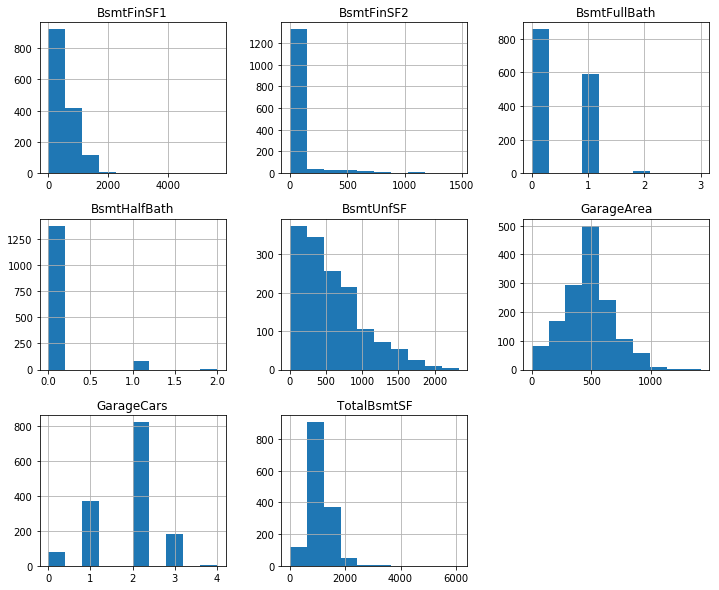

In [25]:
train[dif].hist(figsize = (12,10))
plt.show()

In [26]:
dif

['GarageCars',
 'BsmtUnfSF',
 'GarageArea',
 'BsmtFullBath',
 'TotalBsmtSF',
 'BsmtHalfBath',
 'BsmtFinSF1',
 'BsmtFinSF2']

In [0]:
fil0 = ['BsmtFinSF1',
 'BsmtFullBath',
 'BsmtUnfSF',
 'BsmtFinSF2',
 'BsmtHalfBath']
test[fil0] = test[fil0].fillna(0)
test['GarageCars'] = test['GarageCars'].fillna(2.)
test['TotalBsmtSF'] = test['TotalBsmtSF'].fillna(train['TotalBsmtSF'].median())

#### Check null in categorical columns

In [0]:
dif =list(set(cat_cols_train)-set(cat_cols_test))

In [29]:
train.shape,test.shape

((1460, 80), (1459, 80))

In [30]:
train[dif].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 7 columns):
Utilities      1460 non-null object
KitchenQual    1460 non-null object
Functional     1460 non-null object
Exterior2nd    1460 non-null object
Exterior1st    1460 non-null object
MSZoning       1460 non-null object
SaleType       1460 non-null object
dtypes: object(7)
memory usage: 79.9+ KB


In [31]:
test[dif].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 7 columns):
Utilities      1457 non-null object
KitchenQual    1458 non-null object
Functional     1457 non-null object
Exterior2nd    1458 non-null object
Exterior1st    1458 non-null object
MSZoning       1455 non-null object
SaleType       1458 non-null object
dtypes: object(7)
memory usage: 79.9+ KB


In [32]:
for col in dif:
    print(col)
    test[col] = test[col].fillna(value=str(train[col].mode()[0]))

Utilities
KitchenQual
Functional
Exterior2nd
Exterior1st
MSZoning
SaleType


In [33]:
test[dif].info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 7 columns):
Utilities      1459 non-null object
KitchenQual    1459 non-null object
Functional     1459 non-null object
Exterior2nd    1459 non-null object
Exterior1st    1459 non-null object
MSZoning       1459 non-null object
SaleType       1459 non-null object
dtypes: object(7)
memory usage: 79.9+ KB


In [34]:
test.KitchenQual.value_counts()

TA    758
Gd    565
Ex    105
Fa     31
Name: KitchenQual, dtype: int64

In [0]:
combined = train.append(test)
combined.reset_index(inplace=True)
combined.drop(['index', 'Id'], inplace=True, axis=1)

In [36]:
num_cols = get_cols_with_no_nans(combined , 'num')
cat_cols = get_cols_with_no_nans(combined , 'no_num')
print ('Number of numerical columns with no nan values :',len(num_cols))
print ('Number of nun-numerical columns with no nan values :',len(cat_cols))

Number of numerical columns with no nan values : 32
Number of nun-numerical columns with no nan values : 27


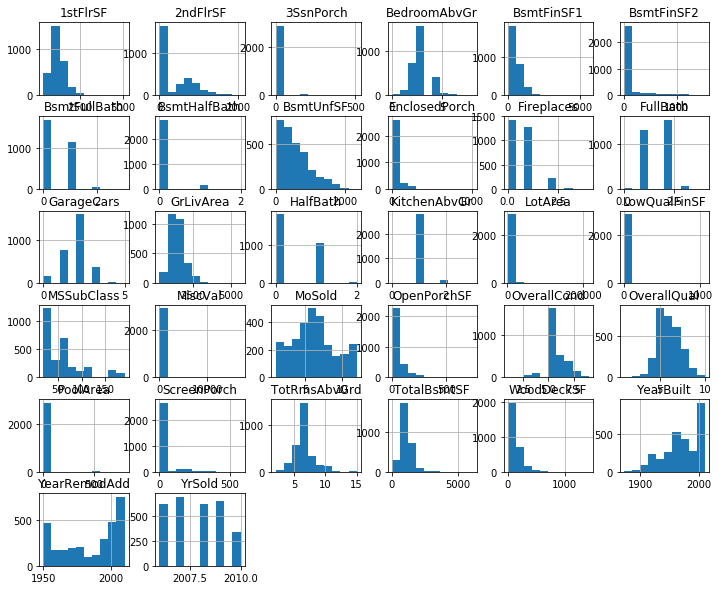

In [37]:
combined = combined[num_cols + cat_cols]
combined.hist(figsize = (12,10))
plt.show()

## Manage categorial variable

In [38]:
def oneHotEncode(df,colNames):
    for col in colNames:
        if( df[col].dtype == np.dtype('object')):
            dummies = pd.get_dummies(df[col],prefix=col)
            df = pd.concat([df,dummies],axis=1)

            #drop the encoded column
            df.drop([col],axis = 1 , inplace=True)
    return df
    

print('There were {} columns before encoding categorical features'.format(combined.shape[1]))
combined = oneHotEncode(combined, cat_cols)
print('There are {} columns after encoding categorical features'.format(combined.shape[1]))

There were 59 columns before encoding categorical features
There are 214 columns after encoding categorical features


In [0]:
## Split back
train = combined[:1460]
test = combined[1460:]

### Normalize

## Regression Loss functions
### The mean absolute percentage error (MAPE)
MAPE, also known as mean absolute percentage deviation (MAPD), is a measure of prediction accuracy of a forecasting method in statistics, for example in trend estimation, also used as a Loss function for regression problems in Machine Learning. It usually expresses accuracy as a percentage, and is defined by the formula:

$${\displaystyle {\mbox{M}}={\frac {100\%}{n}}\sum _{t=1}^{n}\left|{\frac {A_{t}-F_{t}}{A_{t}}}\right|,} {\displaystyle {\mbox{M}}={\frac {100\%}{n}}\sum _{t=1}^{n}\left|{\frac {A_{t}-F_{t}}{A_{t}}}\right|,}$$
where $A_t$ is the actual value and $F_t$ is the forecast value. The difference between $A_t$  and $F_t$ is divided by the actual value $A_t$  again. The absolute value in this calculation is summed for every forecasted point in time and divided by the number of fitted points n. Multiplying by 100% makes it a percentage error.

* https://en.wikipedia.org/wiki/Mean_absolute_percentage_error

### mean_absolute_error
### mean_squared_error
### mean_squared_logarithmic_error

## Build Keras model - train and predict

In [40]:
def get_model():
    
    NN_model = Sequential()

    # The Input Layer :
    NN_model.add(Dense(128, kernel_initializer='normal',input_dim = train.shape[1], activation='relu'))

    # The Hidden Layers :
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))
    NN_model.add(Dense(256, kernel_initializer='normal',activation='relu'))

    # The Output Layer :
    NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    
    return NN_model
np.random.seed(1235)
NN_model = get_model()

# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', 
                 metrics=['mean_absolute_error'])
NN_model.summary()






Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 128)               27520     
_________________________________________________________________
dense_2 (Dense)              (None, 256)               33024     
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_4 (Dense)              (None, 256)               65792     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 192,385
Trainable params: 192,385
Non-trainable params: 0
_________________________________________________________________


### Monitor Training
* EarlyStopping
* Save best models
* ReduceLROnPlateau

In [41]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
np.random.seed(1235)
epochs = 200
batch_size = 32

checkpoint = ModelCheckpoint('best_model_e200_b32_oAdam.h5', verbose=1, 
                             monitor='val_loss',
                             save_best_only=True, mode='auto') 

early = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=5,
                              verbose=1, mode='auto')

history = NN_model.fit(train, target,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,callbacks=[checkpoint, early],
                    validation_split=0.3)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Train on 1021 samples, validate on 439 samples
Epoch 1/200
1021/1021 [==============================] - 5s 5ms/step - loss: 21.8687 - mean_absolute_error: 176554.8824 - val_loss: 5.0075 - val_mean_absolute_error: 159802.5926

Epoch 00001: val_loss improved from inf to 5.00747, saving model to best_model_e200_b32_oAdam.h5
Epoch 2/200
1021/1021 [==============================] - 0s 215us/step - loss: 1.5710 - mean_absolute_error: 112961.6586 - val_loss: 0.1248 - val_mean_absolute_error: 49583.2969

Epoch 00002: val_loss improved from 5.00747 to 0.12480, saving model to best_model_e200_b32_oAdam.h5
Epoch 3/200
1021/1021 [==============================] - 0s 225us/step - loss: 0.1372 - mean_absolute_error: 57943.2173 - val_loss: 0.1151 - val_mean_absolute_error: 48071.1863

Epoch 00003: val_loss improved from 0.12480 to 0.11509, saving model to best_model_e200_b32_oAdam.h5
Epoch 4/200
1021/1021 [

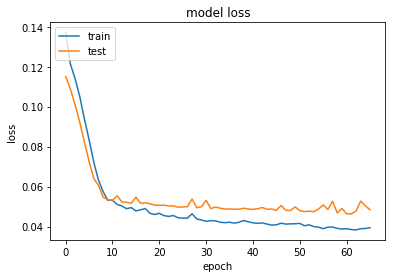

In [42]:
drow_history(history, 'loss', 2)

In [0]:
#### Load the best model
NN_model.load_weights('best_model_e200_b32_oAdam.h5')
# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', 
                 metrics=['mean_absolute_error'])

In [44]:
score=NN_model.evaluate(train, target)

1460/1460 [==============================] - 0s 116us/step


In [45]:
score

[0.04054630268109988, 26634.26052547089]

In [50]:
def make_submission(prediction, sub_name):
    my_submission = pd.DataFrame({'Id':pd.read_csv('test.csv').Id,'SalePrice':prediction})
    my_submission.to_csv('{}.csv'.format(sub_name),index=False)
    print('A submission file has been made')

predictions = NN_model.predict(test)
make_submission(predictions[:,0],'submission_oAdam')

A submission file has been made


In [49]:
!ls

best_model_e200_b32_oAdam.h5  sample_submission.csv	train.csv
data_description.txt	      submission_oAdam.csv.csv
sample_data		      test.csv


kaggle result: 0.22215
************************************************************

In [0]:
from google.colab import files
files.download('submission_oAdam.csv') 

## Improvments

Split the data, for better model comparison

In [53]:
X_train, X_test, y_train, y_test = train_test_split(train, target, test_size=.3, 
                                                    random_state=42)
X_train.head()

,MSSubClass,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageCars,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,MSZoning_C (all),MSZoning_FV,MSZoning_RH,MSZoning_RL,MSZoning_RM,Street_Grvl,Street_Pave,LotShape_IR1,...,Heating_GasW,Heating_Grav,Heating_OthW,Heating_Wall,HeatingQC_Ex,HeatingQC_Fa,HeatingQC_Gd,HeatingQC_Po,HeatingQC_TA,CentralAir_N,CentralAir_Y,KitchenQual_Ex,KitchenQual_Fa,KitchenQual_Gd,KitchenQual_TA,Functional_Maj1,Functional_Maj2,Functional_Min1,Functional_Min2,Functional_Mod,Functional_Sev,Functional_Typ,PavedDrive_N,PavedDrive_P,PavedDrive_Y,SaleType_COD,SaleType_CWD,SaleType_Con,SaleType_ConLD,SaleType_ConLI,SaleType_ConLw,SaleType_New,SaleType_Oth,SaleType_WD,SaleCondition_Abnorml,SaleCondition_AdjLand,SaleCondition_Alloca,SaleCondition_Family,SaleCondition_Normal,SaleCondition_Partial
135,20,10400,7,6,1970,1970,0.0,0.0,1304.0,1304.0,1682,0,0,1682,0.0,0.0,2,0,3,1,7,1,2.0,98,0,0,0,0,0,0,5,2008,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
1452,180,3675,5,5,2005,2005,547.0,0.0,0.0,547.0,1072,0,0,1072,1.0,0.0,1,0,2,1,5,0,2.0,0,28,0,0,0,0,0,5,2006,0,0,0,0,1,0,1,0,...,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
762,60,8640,7,5,2009,2009,24.0,0.0,732.0,756.0,764,783,0,1547,0.0,0.0,2,1,3,1,7,0,2.0,169,45,0,0,0,0,0,6,2010,0,1,0,0,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0
932,20,11670,9,5,2006,2006,0.0,0.0,1905.0,1905.0,1905,0,0,1905,0.0,0.0,2,0,3,1,8,1,3.0,0,191,0,0,0,0,0,3,2007,0,0,0,1,0,0,1,1,...,0,0,0,0,1,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,1,0
435,60,10667,7,6,1996,1996,385.0,344.0,70.0,799.0,827,834,0,1661,1.0,0.0,2,1,3,1,6,1,2.0,158,61,0,0,0,0,0,4,2009,0,0,0,1,0,0,1,0,...,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0


In [0]:
np.random.seed(1235)
NN_model = get_model()

# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', 
                 metrics=['mean_absolute_error'])

In [55]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
np.random.seed(1235)
epochs = 200
batch_size = 32

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2,
                              patience=5, min_lr=0.00001, verbose=1)

checkpoint = ModelCheckpoint('best_model_e200_b32_oadam_lr.h5', verbose=1, 
                             monitor='val_loss',
                             save_best_only=True, mode='auto') 

early = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=1, mode='auto')

history = NN_model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,callbacks=[checkpoint, early, reduce_lr],
                    validation_data=(X_test, y_test))

Train on 1022 samples, validate on 438 samples
Epoch 1/200
1022/1022 [==============================] - 1s 610us/step - loss: 20.9905 - mean_absolute_error: 175308.8878 - val_loss: 4.2798 - val_mean_absolute_error: 157228.3307

Epoch 00001: val_loss improved from inf to 4.27982, saving model to best_model_e200_b32_oadam_lr.h5
Epoch 2/200
1022/1022 [==============================] - 0s 214us/step - loss: 1.2802 - mean_absolute_error: 106848.6608 - val_loss: 0.1355 - val_mean_absolute_error: 52806.7389

Epoch 00002: val_loss improved from 4.27982 to 0.13548, saving model to best_model_e200_b32_oadam_lr.h5
Epoch 3/200
1022/1022 [==============================] - 0s 206us/step - loss: 0.1354 - mean_absolute_error: 57076.3923 - val_loss: 0.1305 - val_mean_absolute_error: 52515.2989

Epoch 00003: val_loss improved from 0.13548 to 0.13050, saving model to best_model_e200_b32_oadam_lr.h5
Epoch 4/200
1022/1022 [==============================] - 0s 221us/step - loss: 0.1220 - mean_absolute_error

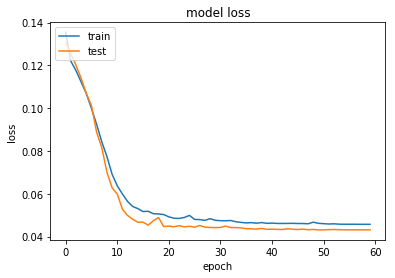

In [56]:
drow_history(history, 'loss', 2)

In [0]:
#### Load the best model
NN_model.load_weights('best_model_e200_b32_oadam_lr.h5')
# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', 
                 metrics=['mean_absolute_error'])

In [58]:
score=NN_model.evaluate(X_test, y_test)
score

438/438 [==============================] - 0s 430us/step


[0.04309418520222516, 28146.384453481736]

In [59]:
score=NN_model.evaluate(train, target)
score

1460/1460 [==============================] - 0s 63us/step


[0.0451003445542022, 28629.494124571916]

In [60]:
predictions = NN_model.predict(test)
make_submission(predictions[:,0],'submission_oadam_lr')

A submission file has been made


* kaggle result  0.22401
**********************************************************************************

In [61]:
np.random.seed(1235)
    
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(128, kernel_initializer='normal',
                       input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))
    

# mean_squared_logarithmic_error
# mean_absolute_error
# mean_squared_error


# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='rmsprop', 
                 metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               27520     
_________________________________________________________________
dense_12 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_13 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_14 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 513       
Total params: 619,393
Trainable params: 619,393
Non-trainable params: 0
_________________________________________________________________


In [62]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
np.random.seed(1235)
epochs = 200
batch_size = 32

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001, verbose=1)

checkpoint = ModelCheckpoint('best_model_e200_b32_rmsprop_net_128_512_512_512.h5', verbose=1, 
                             monitor='val_loss',
                             save_best_only=True, mode='auto') 

early = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=1, mode='auto')

history = NN_model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,callbacks=[checkpoint, early, reduce_lr],
                    validation_data=(X_test, y_test))

Train on 1022 samples, validate on 438 samples
Epoch 1/200
1022/1022 [==============================] - 1s 600us/step - loss: 7.6481 - mean_absolute_error: 108479.0418 - val_loss: 0.1612 - val_mean_absolute_error: 58208.4387

Epoch 00001: val_loss improved from inf to 0.16115, saving model to best_model_e200_b32_rmsprop_net_128_512_512_512.h5
Epoch 2/200
1022/1022 [==============================] - 0s 241us/step - loss: 0.1384 - mean_absolute_error: 56959.5367 - val_loss: 0.1256 - val_mean_absolute_error: 50884.3818

Epoch 00002: val_loss improved from 0.16115 to 0.12563, saving model to best_model_e200_b32_rmsprop_net_128_512_512_512.h5
Epoch 3/200
1022/1022 [==============================] - 0s 214us/step - loss: 0.0997 - mean_absolute_error: 46995.0202 - val_loss: 0.0783 - val_mean_absolute_error: 38769.1937

Epoch 00003: val_loss improved from 0.12563 to 0.07830, saving model to best_model_e200_b32_rmsprop_net_128_512_512_512.h5
Epoch 4/200
1022/1022 [==============================

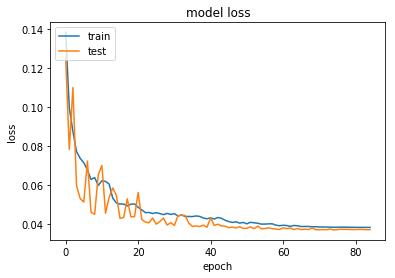

In [63]:
drow_history(history, 'loss', 1)

In [0]:
#### Load the best model
NN_model.load_weights('best_model_e200_b32_rmsprop_net_128_512_512_512.h5')
# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', 
                 metrics=['mean_absolute_error'])

In [65]:
score=NN_model.evaluate(X_test, y_test)
score

438/438 [==============================] - 0s 490us/step


[0.03705601324433606, 25570.829890839042]

In [66]:
score=NN_model.evaluate(train, target)
score

1460/1460 [==============================] - 0s 62us/step


[0.03801739062756708, 25731.854163099317]

In [67]:
predictions = NN_model.predict(test)
make_submission(predictions[:,0],'submission_rmsprop_net_128_512_512_512')

A submission file has been made


* Result 0.20622

******************************************************************

* Enlarge the first Layer
* Drop the last Layer
* reduce batch size

In [68]:
np.random.seed(1235)
    
NN_model = Sequential()

# The Input Layer :
NN_model.add(Dense(264, kernel_initializer='normal',
                       input_dim = train.shape[1], activation='relu'))

# The Hidden Layers :
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))
NN_model.add(Dense(512, kernel_initializer='normal',activation='relu'))

# The Output Layer :
NN_model.add(Dense(1, kernel_initializer='normal',activation='linear'))


# mean_squared_logarithmic_error
# mean_absolute_error
# mean_squared_error


# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='rmsprop', 
                 metrics=['mean_absolute_error'])
NN_model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_16 (Dense)             (None, 264)               56760     
_________________________________________________________________
dense_17 (Dense)             (None, 512)               135680    
_________________________________________________________________
dense_18 (Dense)             (None, 512)               262656    
_________________________________________________________________
dense_19 (Dense)             (None, 1)                 513       
Total params: 455,609
Trainable params: 455,609
Non-trainable params: 0
_________________________________________________________________


In [69]:
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
np.random.seed(1235)
epochs = 200
batch_size = 16

reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5,
                              patience=5, min_lr=0.00001, verbose=1)

checkpoint = ModelCheckpoint('best_model_e200_b16_rmsprop_net_264_512_512.h5', verbose=1, 
                             monitor='val_loss',
                             save_best_only=True, mode='auto') 

early = EarlyStopping(monitor='val_loss',
                              min_delta=0,
                              patience=10,
                              verbose=1, mode='auto')

history = NN_model.fit(X_train, y_train,
                    batch_size=batch_size,
                    epochs=epochs,
                    verbose=1,callbacks=[checkpoint, early, reduce_lr],
                    validation_data=(X_test, y_test))

Train on 1022 samples, validate on 438 samples
Epoch 1/200
1022/1022 [==============================] - 1s 794us/step - loss: 2.6487 - mean_absolute_error: 95551.9504 - val_loss: 0.1179 - val_mean_absolute_error: 49873.1885

Epoch 00001: val_loss improved from inf to 0.11787, saving model to best_model_e200_b16_rmsprop_net_264_512_512.h5
Epoch 2/200
1022/1022 [==============================] - 0s 375us/step - loss: 0.0946 - mean_absolute_error: 45389.0175 - val_loss: 0.0824 - val_mean_absolute_error: 41404.7687

Epoch 00002: val_loss improved from 0.11787 to 0.08241, saving model to best_model_e200_b16_rmsprop_net_264_512_512.h5
Epoch 3/200
1022/1022 [==============================] - 0s 389us/step - loss: 0.0753 - mean_absolute_error: 39306.8447 - val_loss: 0.0593 - val_mean_absolute_error: 33000.6553

Epoch 00003: val_loss improved from 0.08241 to 0.05925, saving model to best_model_e200_b16_rmsprop_net_264_512_512.h5
Epoch 4/200
1022/1022 [==============================] - 0s 386us/

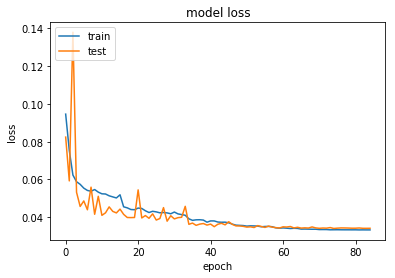

In [70]:
drow_history(history, 'loss', 1)

In [0]:
#### Load the best model
NN_model.load_weights('best_model_e200_b16_rmsprop_net_264_512_512.h5')
# Compile the network :
NN_model.compile(loss='mean_squared_logarithmic_error', optimizer='adam', 
                 metrics=['mean_absolute_error'])

In [72]:
score=NN_model.evaluate(X_test, y_test)
score

438/438 [==============================] - 0s 585us/step


[0.03409179752547992, 23875.68234517694]

In [73]:
score=NN_model.evaluate(X_test, y_test)
score

438/438 [==============================] - 0s 86us/step


[0.03409179752547992, 23875.68234517694]

In [74]:
score=NN_model.evaluate(train, target)
score

1460/1460 [==============================] - 0s 52us/step


[0.03359731672561332, 23837.644343964042]

In [75]:
score=NN_model.evaluate(train, target)
score

1460/1460 [==============================] - 0s 54us/step


[0.03359731672561332, 23837.644343964042]

In [76]:
y_test_pred = NN_model.predict(X_test)
from sklearn.metrics import mean_squared_log_error

mean_squared_log_error(y_test, y_test_pred)

0.034091797705005006

In [77]:
predictions = NN_model.predict(test)
make_submission(predictions[:,0],'submission_rmsprop_net_264_512_512')

A submission file has been made


* result 0.19681

In [0]:
## NextLSTM and time series

In [0]:
https://www.youtube.com/watch?v=ftMq5ps503w
https://www.youtube.com/watch?v=9zhrxE5PQgY&t=44s
https://github.com/llSourcell/How-to-Predict-Stock-Prices-Easily-Demo/blob/master/stockdemo.ipynb